# Measure Watson Assistant Performance 

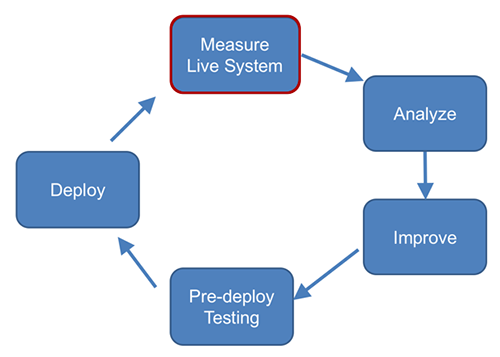

## Introduction

This notebook demonstrates how to setup automated metrics that help you measure, monitor, and understand the behavior of your Watson Assistant system. As described in Watson Assistant Continuous Improvement Best Practices, this is the first step of your continuous improvement process. The goal of this step is to understand where your assistant is doing well vs where it isn’t and to potentially focus your improvement effort to one of the problem areas identified. We define two measures to achieve this goal: **Converage** and **Effectiveness**

- **Converage** is the portion of total conversations or user messages your assistant is attempting to respond to.

- **Effectiveness** refers to how well your assistant is handling the conversations or user messages it is attempting to respond to.

The pre-requisite for running this notebook is Watson Assistant (formerly Watson Conversation). This notebook assumes familiarity with Watson Assistant and concepts such as workspaces, intents and training examples. 

### Programming language and environment
Some familiarity with Python is recommended. This notebook runs on Python 3.5 with Default Python 3.5 XS environment.
***

## Table of contents

1. [Configuration and setup](#setup)<br>
    1.1 [Install required Python libraries](#setup1)<br>
    1.2 [Import functions used in the notebook](#setup2)<br>
    1.3 [Add Cloud Object Store (COS) credentials and create a COS client](#setup3)<br>
    1.4 [Add project token](#setup4)<br>
    1.5 [Add Watson Assistant configuration](#setup5)<br>
    1.6 [Import and apply global CSS styles](#setup6)<br>
2. [Load and format data](#load)<br>
    2.1 [Connect to assistant](#load1)<br>
    2.2 [Fetching workspace](#load2)<br>
    2.3 [Fetching workspace logs](#load3)<br>
    2.4 [Formatting data](#load4)<br>
3. [Define coverage and effectiveness metrics](#set_metrics)<br>
    3.1 [Customize coverage](#set_coverage)<br>
    3.2 [Customize effectiveness](#set_effectiveness)<br>
4. [Calculate overall coverage and effectiveness](#overall)<br>
    4.1 [Calculate overall metrics](#overall1)<br>
    4.2 [Display overall results](#overall2)<br>
5. [Analyze coverage](#msg_analysis)<br>
    5.1 [Display overall coverage](#msg_analysis1)<br>
    5.2 [Calculate coverage over time](#msg_analysis2)<br>
6. [Analyze effectiveness](#conv_analysis)<br>
    6.1 [Generate excel file and upload to Cloud Object Storage](#conv_analysis1)<br>
    6.2 [Plot breakdown by effectiveness graph](#conv_analysis2)<br>
7. [Root cause analysis of non coverage](#root_cause)<br>
8. [Summary and next steps](#summary)<br>


<a id="setup"></a>
## 1. Configuration and Setup

In this section, we add data and workspace access credentials, import required libraries and functions.

<a id="setup1"></a>
### 1.1 Install required Python libraries

In [1]:
# install watson-developer-cloud python SDK
# After running this cell once, comment out the following code. Packages only need to be installed once.
!pip install --upgrade "watson-developer-cloud>=1.0,<2.0";

# Import required libraries
import pandas as pd
from botocore.client import Config
import ibm_boto3
import datetime
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
from IPython.display import display, HTML
from watson_developer_cloud import AssistantV1
from datetime import timedelta
import matplotlib.dates as mdates
import re
from project_lib import Project
import random

pd.set_option('max_colwidth', -1)

Requirement already up-to-date: watson-developer-cloud<2.0,>=1.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: python-dateutil>=2.5.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: service-identity>=17.0.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: pyOpenSSL>=16.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: requests<3.0,>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not upgraded as not directly required: autobahn>=0.10.9 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud<2.0,>=1.0)
Requirement not up

### <a id="setup2"></a> 1.2 Import functions used in the notebook

#### 1.2.1 Import function module files

In [2]:
# The following line will be removed after moving to Watson developer cloud
# @hidden_cell
credentials = {
    'IBM_API_KEY_ID': '***',
    'IAM_SERVICE_ID': '***',
    'ENDPOINT': '***',
    'IBM_AUTH_ENDPOINT': '***',
    'BUCKET': '***'
}

# The following line will be removed after moving to Watson developer cloud
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

# Load Cloud Object Storage functions
streaming_body = cos_client.get_object(Bucket=credentials['BUCKET'], Key='cos_op.py')['Body']
with open('cos_op.py', 'wb') as f:
    f.write(streaming_body.read())
    
# Load Watson Assistant functions
streaming_body = cos_client.get_object(Bucket=credentials['BUCKET'], Key='watson_assistant_func.py')['Body']
with open('watson_assistant_func.py', 'wb') as f:
    f.write(streaming_body.read())

# Load visualization functions
streaming_body = cos_client.get_object(Bucket=credentials['BUCKET'], Key='visualize_func.py')['Body']
with open('visualize_func.py', 'wb') as f:
    f.write(streaming_body.read())

# Load dataframe computation functions
streaming_body = cos_client.get_object(Bucket=credentials['BUCKET'], Key='computation_func.py')['Body']
with open('computation_func.py', 'wb') as f:
    f.write(streaming_body.read())

#### 1.2.2 Import functions

In [3]:
# Import the visualization related functions
from visualize_func import render_fig
from visualize_func import make_pie
from visualize_func import coverage_barh
from visualize_func import width_bar

# Import Cloud Object Storage related functions   
from cos_op import generate_link
from cos_op import generate_excel

# Import Watson Assistant related functions
from watson_assistant_func import get_logs

# Import Dataframe computation related functions
from computation_func import intersection
from computation_func import get_effective_df
from computation_func import get_coverage_df
from computation_func import chk_is_valid_node
from computation_func import format_data

### <a id="setup3"></a> 1.3 Add Cloud Object Store (COS) credentials and create a COS client

- Click the Find and Add Data icon (<img src="https://dataplatform.cloud.ibm.com/docs/api/content/console/images/find_data_icon.png" style="display: inline-block" />) and then browse a data file
- Click in an empty line in the following celland then click the Insert to code > Insert Credentials function from the Files notebook sidebar
- You may keep or remove `FILE` field from `credentials`

In [4]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IBM_API_KEY_ID': '***',
    'IAM_SERVICE_ID': '***',
    'ENDPOINT': '***',
    'IBM_AUTH_ENDPOINT': '***',
    'BUCKET': '***'
}

# Create a cloud object store connection
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In order to make this notebook to be able to generate downloadable links, we need to add the service credentials of the corresponding COS instance
- Launch your <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage</a> instance from <a href="https://console.bluemix.net/dashboard/apps" target="_blank" rel="noopener no referrer">IBM Cloud Dashboard</a>.
- In the **Service credentials** tab, locate notebook credentials, e.g., "\*\*\*donotdelete***"
- Add `access_key_id` and `secret_access_key` values below.

In [5]:
# @hidden_cell
cos_access_credentials = {
    # Add the secret access_key and access_key_id from COS here
    'secret_access_key': '***',
    'access_key_id': '***',
    'host': 's3-api.us-geo.objectstorage.softlayer.net'
}

credentials.update(cos_access_credentials)

# Define the expiration time in seconds
configuration = {
    'OUTPUT_EXPIRATION': 86400 
}

### <a id="setup4"></a> 1.4 Add project token

Project token is used to access data assets from notebooks. For more information about project tokens, see [project token](https://dataplatform.cloud.ibm.com/docs/content/analyze-data/token.html).

In [6]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
project = Project(project_id='***', project_access_token='***')
pc = project.project_context

### <a id="setup5"></a> 1.5 Add Watson Assistant configuration

Provide your Watson Assistant credentials and the workspace id that you want to fetch data from.   

- For more information about obtaining Watson Assistant credentials, see [Service credentials for Watson services](https://console.bluemix.net/docs/services/watson/getting-started-credentials.html#creating-credentials) 
- API requests require a version parameter that takes a date in the format version=YYYY-MM-DD. For more information about version, see [Versioning](https://www.ibm.com/watson/developercloud/assistant/api/v1/curl.html?curl#versioning)


In [7]:
# Provide credentials to connect to assistant
creds = {'username':'***',
         'password':'***',
         'version':'2018-05-03'}

# Provide the workspace id you want to analyze
workspace_id = '***'

### <a id="setup6"></a> 1.6 Import and apply global CSS styles

In [8]:
#apply custom style to notebbok
body = cos_client.get_object(Bucket=credentials['BUCKET'], Key='custom.css')['Body']
styles = body.read().decode('utf-8')
HTML(styles)

## <a id="load"></a> 2. Load and format data 

### 2.1 <a id="load1"></a> Connect to Watson Assistant instance

In [9]:
# Connect to Watson Assistant
conversation = AssistantV1(username=creds['username'], 
                           password=creds['password'], 
                           version=creds['version'])

### <a id="load2"></a> 2.2 Fetch workspace

Fetch the workspace for the workspace id given in `workspace_id` variable <br>

In [10]:
# Fetch the worksapce info. for the input workspace id
workspace = conversation.get_workspace(workspace_id = workspace_id, export=True)

# Store the workspace details in a dataframe
df_workspace = json_normalize(workspace)

# Get all intents present in current version of workspace
workspace_intents= [intent['intent'] for intent in df_workspace['intents'].values[0]] 

# Get all dialog nodes present in current version of workspace
workspace_nodes= pd.DataFrame(df_workspace['dialog_nodes'].values[0])

<a id="load3"></a>
### 2.3 Fetch workspace logs

Fetch the logs for the workspace id given in `workspace_id` variable. Any necessary filter can be specified in the `filter` variable.<br>
_**Note:** If the logs were already fetched in a previous run, it will be read from the COS for subsequent runs_

In [11]:
# Filter to be applied while fetching logs, e.g., removing empty input 'meta.summary.input_text_length_i>0', 'response_timestamp>=2018-09-18'
filter = 'meta.summary.input_text_length_i>0'

# Send this info into the get_logs function
project_creds={'project':project, 'cos':cos_client, 'bucket':credentials['BUCKET'],'sdk_object':conversation, 'ws_id':workspace['workspace_id'], 'ws_name':workspace['name']}
        
# Fetch the logs for the workspace
df = get_logs(num_logs=10000, log_list=[], project_creds=project_creds, log_filter=filter)

Reading from file: Car Dashboard - Samplemeta.summary.input_text_length_i0_10000.json
Workspace logs loaded successfully with 7619 records


### <a id="load4"></a> 2.4 Formatting data

In [12]:
# Format the logs data from the workspace
df_formated = format_data(df)

<a id="set_metrics"></a>
## 3. Define effectiveness and coverage metrics
As described in Watson Assistant Continuous Improvement Best Practices, **Effectiveness** and **Coverage** are the two measures that provide a reliable understanding of your assistant’s overall performance. Both of the two measures are customizable based on your preferences. In this section, we provide a guideline for setting each of them.

### <a id="set_coverage"></a> 3.1 Customize coverage

Coverage measures your Watson Assistant system at the utterance level. You may include automated metrics that help identify utterences that your service is not answering. Example metrics include: 

- Confidence threshold
- Dialog information

Dialog information is based on node id, node name, and node condition. To locate the corresponding values, refer to Section 3.1.2. For more information on Confidence, see [Absolute scoring](https://console.bluemix.net/docs/services/conversation/intents.html#absolute-scoring-and-mark-as-irrelevant).

Below we provide example code for identifying coverage based on confidence and dialog node. 

In [13]:
#Specify the confidence threhold you want to look for in the logs
confidence_threshold = .20

# Add coverage node ids, if any, to list
node_ids = ['node_1_1467910920863', 'node_1_1467919680248']

# Add coverage node names, if any, to list
node_names = []

# Add coverage node conditions, if any, to list
node_conditions = ['#out_of_scope || #off_topic', 'anything_else']

# Check if the dialog nodes are present in the current version of workspace
df_coverage_nodes = chk_is_valid_node(node_ids, node_names, node_conditions, workspace_nodes)
df_coverage_nodes

,conditions,dialog_node,title,type,valid
0,true,node_1_1467910920863,NaN,standard,True
1,true,node_1_1467919680248,NaN,standard,True
2,#out_of_scope || #off_topic,node_1_1467743415843,NaN,standard,True
3,anything_else,node_2_1487280430136,NaN,standard,True


### <a id="set_effectiveness"></a> 3.2 Customize effectiveness

Effectiveness measures your Watson Assistant system at the conversation level. You may include automated metrics that help identify problematic conversations. Example metrics include:

- Escalations to live agent: conversations escalated to a human agent for quality reasons
- Poor NPS: conversations that received a poor NPS (Net Promoter Score), or other explicit user feedback
- Task not completed: conversations failed to complete the task the user was attempting
- Implicit feedback: conversations containing implicit feedback that suggests failure, such as links provided not being clicked 

Below we provide example code for identifying escalation based on intents and dialog information.

#### <a id="set_escalation_intent"></a> 3.2.1 Specify intents to identify escalations
If you have specific intents that point to escalation or any other effectiveness measure, specify those in `chk_effective_intents` lists below. <br>
**Note:** If you don't have specific intents to capture effectiveness, leave chk_effective_intents list empty.

In [14]:
# Add your escalation intents to the list
chk_effective_intents=['connect_to_agent']

# Store the intents in a dataframe
df_chk_effective_intents = pd.DataFrame(chk_effective_intents, columns = ['intent'])

# Add a 'valid' flag to the dataframe
df_chk_effective_intents['valid']= True

# Checking the validity of the specified intents. Look out for the `valid` column in the table displayed below.
for intent in chk_effective_intents:
    # Check if intent is present in workspace
    if intent not in workspace_intents:
        # If not present, mark it as 'not valid'
        df_chk_effective_intents.loc[df_chk_effective_intents['intent']==intent,['valid']] = False
        # Remove intent from the chk_effective_intents list 
        chk_effective_intents.remove(intent)
# Display intents and validity
df_chk_effective_intents

,intent,valid
0,connect_to_agent,True


#### <a id="set_escalation_dialog"></a> 3.2.2 Specify  dialog nodes to identify escalations
If you have specific dialog nodes that point to escalation or any other effectiveness measure, you can automated capture them based on three variables: node id, node name, and node condition.

You can find the values of these variables from your workspace JSON file based on following mappings.

- node id: `dialog_node`
- node name: `title`
- node condition: `conditions`

You can also find node name, and node condition in your workspace dialog editor. For more information, see [Dialog Nodes](https://console.bluemix.net/docs/services/conversation/dialog-overview.html#dialog-nodes)

**Note:** If your assistant does not incorporate escalations and you do not have any other automated conversation-level quality metrics to identify problematic conversations (e.g., poor NPS, task not completed), you can simply track coverage and average confidence over a recent sample of your entire production logs. Leave an empty list for node_ids, node_names and node_conditions.  

In [15]:
# Add effectiveness node ids, if any, to list
node_ids = []

# Add effectiveness node names, if any, to list
node_names = ['not_trained']

# Add effectiveness node conditions, if any, to list
node_conditions = ['#connect_to_agent', '#answer_not_helpful']

# If your assistant does not incorporate escalations and you do not have any other automated conversation-level quality metrics, uncomment lines below 
# node_ids = [] 
# node_names = [] 
# node_conditions = [] 

# Check if the dialog nodes are present in the current version of workspace
df_chk_effective_nodes = chk_is_valid_node(node_ids, node_names, node_conditions, workspace_nodes)
df_chk_effective_nodes

,conditions,dialog_node,title,type,valid
0,#connect_to_agent,node_2_1537212368188,NaN,standard,True
1,#answer_not_helpful,node_1_1537212185418,NaN,standard,True
2,#not_trained,node_1_1537297843450,not_trained,standard,True


## 4. Calculate overall coverage and effectiveness<a id="overall"></a>

The combination of effectiveness and coverage is very powerful for diagnostics.
If your effectiveness and coverage metrics are high, it means that your assistant is responding to most inquiries and responding well. If either effectiveness or coverage are low, the metrics provide you with the information you need to start improving your assistant. 


###  4.1 Calculate overall metrics<a id="overall1"></a>

In [16]:
df_formated_copy = df_formated.copy(deep = True)

# Mark if a message is covered and store results in df_coverage dataframe
df_coverage = get_coverage_df(df_formated_copy , df_coverage_nodes, confidence_threshold)

# Mark if a conversation is effective and store results in df_coverage dataframe
df_effective = get_effective_df(df_formated_copy, chk_effective_intents, df_chk_effective_nodes)

# Calculate average confidence
avg_conf = float("{0:.2f}".format(df_coverage[df_coverage['Covered']==True]['response.top_intent_confidence'].mean()*100))

# Calculate coverage
coverage = float("{0:.2f}".format((df_coverage['Covered'].value_counts().to_frame()['Covered'][True]/df_coverage['Covered'].value_counts().sum())*100))

# Calculate effectiveness
effective_perc = float("{0:.2f}".format((df_effective.loc[df_effective['Escalated_conversation']==False]['response.context.conversation_id'].nunique()/df_effective['response.context.conversation_id'].nunique())*100))              

# Plot pie graphs for coverage and effectiveness
coverage_pie = make_pie(coverage, "Percent of total messages covered")
effective_pie = make_pie(effective_perc, 'Percent of non-escalated conversations')

Messages to be displayed with coverage and effectiveness metrics are given below

In [17]:
# Messages to be displayed with effectiveness and coverage
coverage_msg = '<h2>Coverage</h2></br>A message that is not covered would either be a \
message your assistant responded to with some form \
of “I’m not trained” or that it immediately handed over \
to a human agent without attempting to respond'

effectiveness_msg = '<h2>Effectiveness</h2></br>This notebook will provide a list of metrics customers \
can use to assess how effective their assistant is at \
responding to conversation and metrics '

###  4.2 Display overall results<a id="overall2"></a>



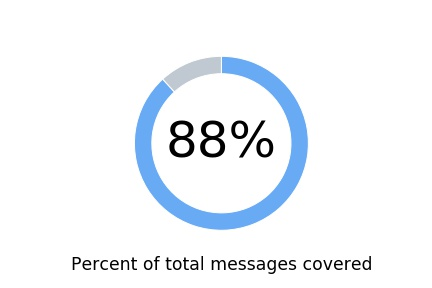
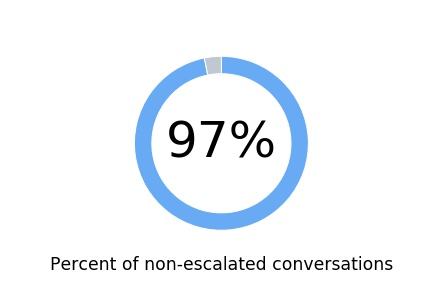

In [18]:
# Display the coverage and effectiveness pie charts
HTML('<tr><th colspan="4"><div align="center"><h2>Coverage and Effectiveness<hr/></h2></div></th></tr>\
<tr>\
    <td style="width:500px">{c_pie}</td>\
    <td style="width:450px"><div align="left"> {c_msg} </div></td>\
    <td style="width:500px">{e_pie}</td>\
    <td style="width:450px"><div align="left"> {e_msg}  </div></td>\
</tr>'
    .format(c_pie=coverage_pie, c_msg = coverage_msg, e_pie = effective_pie, e_msg = effectiveness_msg))

Here, we can see our assistant's coverage and effectiveness. We will have to take a deeper look at both of these metrics to understand the nuances and decide where we should focus next. 

**Note the distinction between a user message and a conversation.**  
A conversation in Watson Assistant represents a session of one or more messages from a user and the associated responses returned to the user from the assistant. <br>
A conversation includes a Conversation Id for the purposes of grouping a sequence of messages and responses. 

<a id="msg_analysis"></a>
## 5.  Analyze coverage

Here, we will take a deeper look at Coverage of the assistant


###  5.1 Display overall coverage<a id="msg_analysis1"></a>


Overall messages
Total Conversations: 4298
Total Messages: 7619




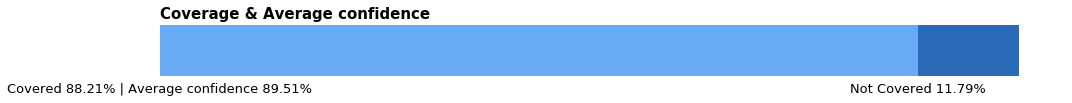

In [19]:
%matplotlib inline  

# Compute the number of conversations in the log
convs = df_coverage['response.context.conversation_id'].nunique()

# Compute the number of messages in the log
msgs = df_coverage['response.context.conversation_id'].size

#Display the results
print('Overall messages\n', "=" * len('Overall messages'), '\nTotal Conversations: ', convs, '\nTotal Messages: ', msgs, '\n\n', sep = '')

#Display the coverage bar chart
display(coverage_barh(coverage, avg_conf, 'Coverage & Average confidence', False))

Here, we see the percentage of messages covered and their average confidence. Now, let us take a look at the coverage over time.


###  5.2 Calculate coverage over time<a id="msg_analysis2"></a>


In [20]:
# Make a copy of df_coverage dataframe
df_Tbot_raw1 = df_coverage.copy(deep=True)

# Group by date and covered and compute the count
covered_counts = df_Tbot_raw1[['Date','Covered']].groupby(['Date','Covered']).agg({'Covered': 'count'})

# Convert numbers to percentage
coverage_grp = covered_counts.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).rename(columns = {'Covered':'Coverage'}).reset_index()

# Get only covered messages
coverage_time = coverage_grp[coverage_grp['Covered']==True].reset_index(drop = True)

# Determine the number of xticks required
xticks = [d for d in coverage_time['Date']]

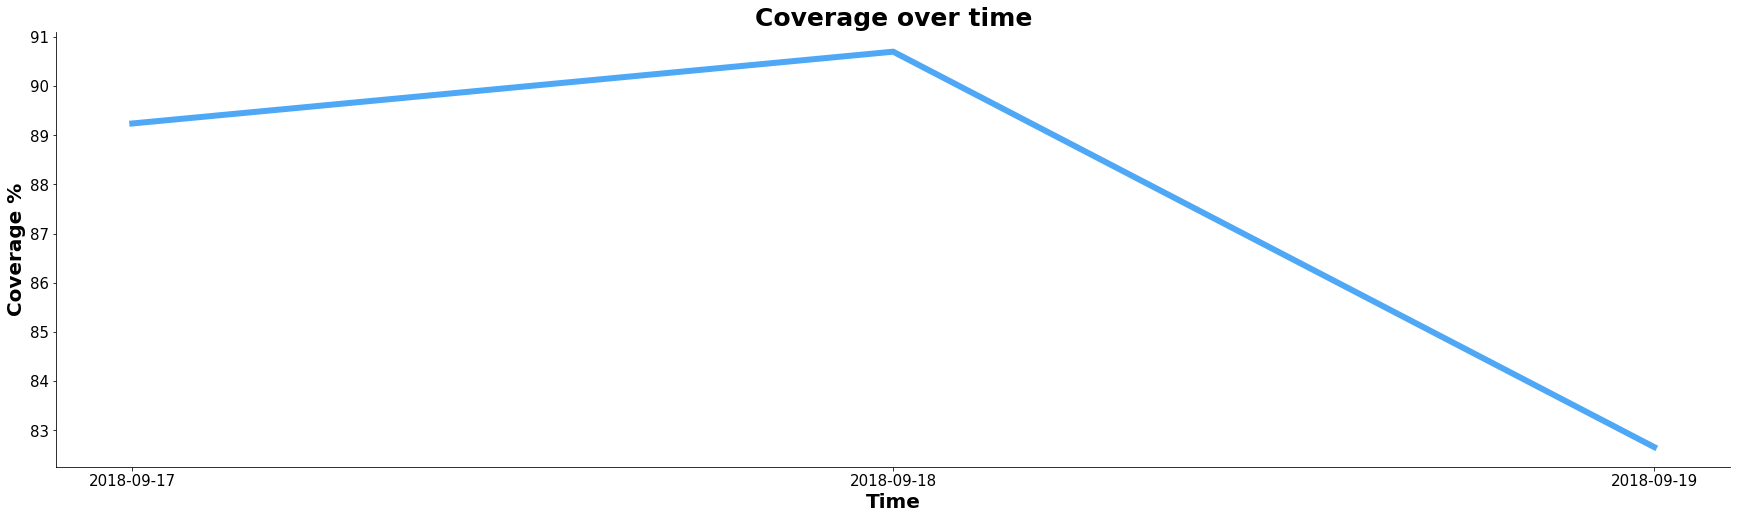

In [21]:
# Plot the coverage over time graph
fig, ax = plt.subplots(figsize=(30,8))

# Format the date on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis_date()
ax.set_xticks(xticks)

# Plot a line plot if there are more data points
if len(coverage_time) >1:
    ax.plot_date(coverage_time['Date'], coverage_time['Coverage'], fmt = '-', color = '#4fa8f6', linewidth=6)
# Plot a scatter plot if there is only one date on x-axis
else:
    ax.plot_date(coverage_time['Date'], coverage_time['Coverage'], color = '#4fa8f6', linewidth=6)

# Set axis labels and title
ax.set_xlabel("Time", fontsize=20, fontweight='bold')
ax.set_ylabel("Coverage %", fontsize=20, fontweight='bold')
ax.set_title('Coverage over time', fontsize=25, fontweight = 'bold')
ax.tick_params(axis='both', labelsize=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

**Note:** Compare the coverage over time with any major updates to your assistant, to see if the changes affected the performance.

<a id="conv_analysis"></a>
## 6. Analyze effectiveness

Here, we will take a deeper look at effectiveness of the assistant

In [22]:
# Get the escalated conversations
df_effective_true = df_effective.loc[df_effective['Escalated_conversation']==True]

# Get the non-escalated conversations
df_not_effective = df_effective.loc[df_effective['Escalated_conversation']==False]

# Calculate percentage of escalated conversations
ef_escalated = float("{0:.2f}".format(100-effective_perc))

# Calculate coverage and non-coverage in escalated conversations
if len(df_effective_true) > 0:
    escalated_covered = float("{0:.2f}".format((df_effective_true['Covered'].value_counts().to_frame()['Covered'][True]/df_effective_true['Covered'].value_counts().sum())*100))
    escalated_not_covered = float("{0:.2f}".format(100- escalated_covered))
else:
    escalated_covered = 0
    escalated_not_covered = 0

# Calculate coverage and non-coverage in non-escalated conversations
if len(df_not_effective) > 0:
    not_escalated_covered = float("{0:.2f}".format((df_not_effective['Covered'].value_counts().to_frame()['Covered'][True]/df_not_effective['Covered'].value_counts().sum())*100))
    not_escalated_not_covered = float("{0:.2f}".format(100 - not_escalated_covered))
else:
    not_escalated_covered = 0
    not_escalated_not_covered = 0

# Calculate average confidence of escalated conversations
if len(df_effective_true) > 0:
    esc_avg_conf = float("{0:.2f}".format(df_effective_true[df_effective_true['Covered']==True]['response.top_intent_confidence'].mean()*100))
else:
    esc_avg_conf = 0
    
# Calculate average confidence of non-escalated conversations
if len(df_not_effective) > 0:
    not_esc_avg_conf = float("{0:.2f}".format(df_not_effective[df_not_effective['Covered']==True]['response.top_intent_confidence'].mean()*100))
else:
    not_esc_avg_conf = 0

###  6.1 Generate excel file and upload to Cloud Object Storage<a id="conv_analysis1"></a>


In [23]:
# Copy the effective dataframe
df_excel = df_effective.copy(deep=True)
# Rename columns to generate excel
df_excel = df_excel.rename(columns={'log_id':'Log ID', 'response.context.conversation_id':'Conversation ID',
                           'response.timestamp':'Response Timestamp',
                           'request_input':'Utterance Text',
                           'response_text':'Response Text', 'response.top_intent_intent':'Detected top intent',
                           'response.top_intent_confidence':'Detected top intent confidence',
                           'Intent 2 intent': 'Intent 2', 'Intent 2 confidence':'Intent 2 Confidence', 
                           'Intent 3 intent': 'Intent 3', 'Intent 3 confidence':'Intent 3 Confidence',
                           'response_entities':'Detected Entities', 'Escalated_conversation':'Escalated conversation?',
                           'Covered':'Covered?', 'Not Covered cause':'Not covered - cause',
                           'response.output.nodes_visited_s':'Dialog Flow', 'response_dialog_stack':'Dialog stack',
                           'response_dialog_request_counter':'Dialog request counter', 'response_dialog_turn_counter':'Dialog turn counter'
                           })

existing_columns = ['Log ID', 'Conversation ID', 'Response Timestamp', 'Customer ID (must retain for delete)',
                    'Utterance Text', 'Response Text', 'Detected top intent', 'Detected top intent confidence',
                    'Intent 2', 'Intent 2 Confidence', 'Confidence gap (between 1 and 2)', 'Intent 3', 'Intent 3 Confidence',
                    'Detected Entities', 'Escalated conversation?', 'Covered?', 'Not covered - cause',
                    'Dialog Flow', 'Dialog stack', 'Dialog request counter', 'Dialog turn counter']
# Add new columns for annotating problematic logs
new_columns_excel = ['Response Correct (Y/N)?', 'Response Helpful (Y/N)?', 'Root cause (Problem with Intent, entity, dialog)',
                     'Wrong intent? If yes, put the correct intent. Otherwise leave it blank', 'New intent needed? (A new intent. Otherwise leave blank)',
                     'Add Utterance to Training data', 'Entity missed? If yes, put the missed entity value. Otherwise leave it blank', 'New entity needed? If yes, put the entity name',
                     'New entity value? If yes, put the entity value', 'New dialog logic needed?', 'Wrong dialog node? If yes, put the node name. Otherwise leave it blank','No dialog node triggered']

# Add the new columns to the dataframe
df_excel = df_excel.reindex(columns=[*existing_columns, *new_columns_excel], fill_value='')

In [24]:
# Set maximum sampling size
SAMPLE_SIZE = 200

# Generate all covered sample file
df_covered = df_excel[df_excel['Covered?']==True].reset_index(drop=True)

# Generate all not covered sample file
df_not_covered = df_excel[df_excel['Covered?']==False].reset_index(drop=True)

# Convert to Excel format and upload to COS
generate_excel([df_covered,df_not_covered], ['Covered', 'Not_Covered'], bucket=credentials['BUCKET'], filename='all.xlsx', upload=True, cos_client=cos_client)

# Generate escalated and covered sample file
df_escalated_true = df_excel.loc[df_excel['Escalated conversation?']==True]
df_escalated_covered = df_escalated_true[df_escalated_true['Covered?']==True]
if len(df_escalated_covered) > 0:
    df_escalated_covered = df_escalated_covered.sample(n=min(len(df_escalated_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Generate escalated but not covered sample file
df_escalated_not_covered = df_escalated_true[df_escalated_true['Covered?']==False]
if len(df_escalated_not_covered) > 0:
    df_escalated_not_covered = df_escalated_not_covered.sample(n=min(len(df_escalated_not_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Covert to Excel format and upload to COS
generate_excel([df_escalated_covered,df_escalated_not_covered], ['Covered', 'Not_Covered'], bucket=credentials['BUCKET'], filename= 'Escalated_sample.xlsx', upload=True, cos_client=cos_client)

# Generate not escalated but covered sample file
df_not_escalated = df_excel.loc[df_excel['Escalated conversation?']==False]
df_not_escalated_covered = df_not_escalated[df_not_escalated['Covered?']==True]
if len(df_not_escalated_covered) > 0:
    df_not_escalated_covered = df_not_escalated_covered.sample(n=min(len(df_not_escalated_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Generate not escalated and not covered sample file
df_not_escalated_not_covered = df_not_escalated[df_not_escalated['Covered?']==False]
if len(df_not_escalated_not_covered) > 0:
    df_not_escalated_not_covered = df_not_escalated_covered.sample(n=min(len(df_not_escalated_not_covered), SAMPLE_SIZE), random_state=1).reset_index(drop=True)

# Covert to Excel format and upload to COS
generate_excel([df_not_escalated_covered,df_not_escalated_not_covered], ['Covered', 'Not_Covered'], bucket=credentials['BUCKET'], filename= 'NotEscalated_sample.xlsx', upload=True, cos_client=cos_client)

allSampleLink = generate_link('all.xlsx', credentials, expiration=configuration['OUTPUT_EXPIRATION'])
escalatedSampleLink = generate_link('Escalated_sample.xlsx', credentials, expiration=configuration['OUTPUT_EXPIRATION'])
notEscalatedSampleLink = generate_link('NotEscalated_sample.xlsx', credentials, expiration=configuration['OUTPUT_EXPIRATION'])

###  6.2 Plot breakdown by effectiveness graph<a id="conv_analysis2"></a>


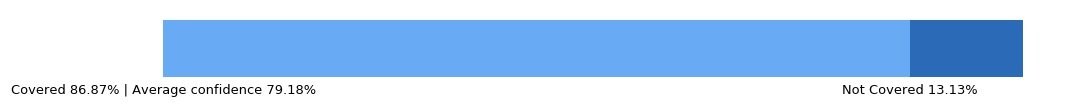
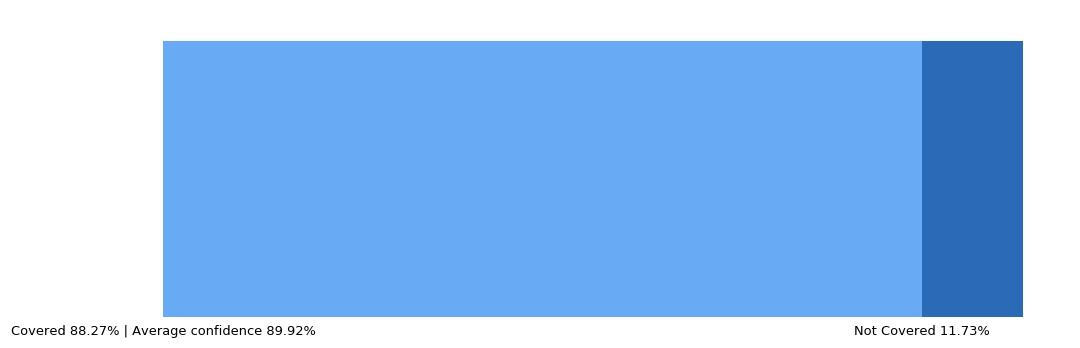

In [25]:
# Get the links to the excels
all_html_link = '<a href={} target="_blank">All.xlsx</a>'.format(allSampleLink)
escalated_html_link = '<a href={} target="_blank">Escalated_sample.xlsx</a>'.format(escalatedSampleLink)
not_escalated_html_link = '<a href={} target="_blank">NotEscalated_sample.xlsx</a>'.format(notEscalatedSampleLink)

# Embed the links in HTML table format
link_html = '<tr><th colspan="4"><div align="left">View the lists here: {}&nbsp;&nbsp;&nbsp;{}&nbsp;&nbsp;&nbsp;{}</div></th></tr>'.format(all_html_link, escalated_html_link, not_escalated_html_link)

if 100-effective_perc > 0:
    escalated_bar = coverage_barh(escalated_covered, esc_avg_conf, '', True, 15, width_bar(100-effective_perc))
else:
    escalated_bar = ''

if effective_perc > 0: 
    non_escalated_bar = coverage_barh(not_escalated_covered, not_esc_avg_conf, '' , True , 15,width_bar(effective_perc))
else:
    non_escalated_bar = ''

# Plot the results
HTML('<tr><th colspan="4"><div align="left"><h2>Breakdown by effectiveness<hr/></h2></div></th></tr>\
'+ link_html + '<tr><td style= "border-right: 1px solid black; border-bottom: 1px solid black; width : 400px"><div align="left"><strong>Effectiveness (Escalated)&nbsp;</br>\
<font size="5">{ef_escalated}%</strong></font size></br></div></td>\
    <td style="width:1000px; height=100;">{one}</td></tr>\
<tr><td style= "border-right: 1px solid black; border-bottom: 1px solid black; width : 400px;"><div align="left"><strong>Effectiveness (Not escalated)&nbsp;</br>\
<font size="5">{effective_perc}%</strong></font size></br></div></td>\
    <td style="width:1000px; height=100;border-bottom: 1px solid black;">{two}</td>\
</tr>'.format(ef_escalated= ef_escalated,
              one = escalated_bar, 
              effective_perc = effective_perc, 
              two = non_escalated_bar)) 


You can download all the analyzed data from `All.xlsx`. A sample of escalated and non-escalated conversations are available in `Escalated_sample.xlsx` and `NotEscalated_sample.xlsx` respectively.


<a id="root_cause"></a>
## 7. Root cause analysis of non coverage
Lets us take a look at the reasons for non-coverage of messages

In [26]:
# Count the causes for non-coverage and store results in dataframe
not_covered = pd.DataFrame(df_coverage['Not Covered cause'].value_counts().reset_index())
# Name the columns in the dataframe
not_covered.columns = ['Messages', 'Total']
not_covered

,Messages,Total
0,'anything_else' node,715
1,'#out_of_scope || #off_topic' node,183


The metrics described above help you narrow your immediate focus of improvement. You can download all the analyzed data from `All.xlsx`. A sample of escalated and non-escalated conversations are available in `Escalated_sample.xlsx` and `NotEscalated_sample.xlsx` respectively. 

<a id="summary"></a>
## 8. Summary and next steps

The following sections outline steps toward improving your assistant. If you have decided to analyze your assistant’s effectiveness/coverage, you will want to perform a deeper analysis on the group of problematic conversations you selected (e.g., the escalated conversations) from the Measure Live System phase.<br>   

For effectiveness, this analysis is performed by: <br>
1. Sampling a random set of user message utterance-response pairs from conversations you are analyzing.<br>
2. Performing a manual assessment of those sampled logs.<br>
3. Analyzing the results using our [Effectiveness Analysis Jupyter Notebook](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/3d9cd51e-4a49-4d42-94d7-07b41646c129/view?access_token=17d7870b91782b802c0406bab0c233f567438530dfcc206b5fa092f8a67e7b85).<br>

**Sampling Questions**-response pairs should be sampled randomly from the group of conversations you chose to investigate in the Measure Live System section. This could be all conversations in your log, or a subset of conversations marked as problematic, such as escalations. For example, if you are analyzing only escalated conversations, then you would randomly sample utterance-response pairs from the escalated conversations. If you are analyzing all conversations, then you would sample utterance-response pairs from all conversations. 

**Performing a Manual Assessment**

A manual assessment is performed as follows.<br>

For each sampled question-response pair:<br>
1. Manually determine whether the response was: 
    - _Correct or incorrect_: Was the response returned by your assistant the response you expected it to give? The percentage of correct responses tells you the precision of your assistant.
    - _Helpful or unhelpful_: If the answer was correct, also mark whether it was helpful.
 
The goal is to identify responses that may be considered technically correct, but the wording of the response is not satisfying to the user. It could be too long, too general, or just worded awkwardly, thus resulting in an overall ineffective response. The exact definition of effective is subjective and can be defined based on your business goals.  The distinction between precision and helpfulness is important because it helps determine where your agent needs improvement.

2. Specify correct system response:  
For each utterance your assistant responded to incorrectly:<br>
a. Identify the root cause by marking whether it was due to an incorrect or absent intent, entity, or dialog response <br>
b. Specify what the correct intent, entity and dialog responses should have been.<br>
         i.If the required intent does not exist, mark it as “new intent needed”
         ii.If the required entity does not exist, mark it as “new entity needed”
         iii.If the required dialog logic does not exist, mark it as “new dialog logic needed”

**Perform Analysis<br>**
Feed the assessment results into our [Effectiveness Analysis Jupyter Notebook](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/3d9cd51e-4a49-4d42-94d7-07b41646c129/view?access_token=17d7870b91782b802c0406bab0c233f567438530dfcc206b5fa092f8a67e7b85) and view the resulting analysis. The notebook will help you understand relative performance of each intent and entity as well as the confusion between your intents. This information helps you prioritize your improvement effort. 

### <a id="authors"></a>Authors

**Zhe Zhang**, PhD, is a Data Scientist in IBM with the the Watson Recommends development team.

**Sherin Varughese** is a Data Scientist in IBM with the the Watson Recommends development team.

#### Copyright for Watson Studio community

<hr>
Copyright &copy; IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.

#### Copyright for DSX Local and DSX Desktop

<hr>
Copyright &copy; IBM Corp. 2018. Sample Materials.

### Share / Sign-up Call-to-Action

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>